In [ ]:
random_seed = 0

**Takeaways**

- Dealing with vanishing, exploding and overfitting


# 11.1 Gradient Vanishing and Exploding

- There are strategies to prevent the unstable gradient

**Initialization Method**

- **He**: ReLU, LeakyReLU, ELU, GELU, Swish, Mish
- **Glorot**: tanh, Logistic, Softmax
- **LeCun**: SELU

**Choosing Actication Functions**

- **ReLU**
- **LeackyReLU**
  ...

**Batch Normaliztion**

**Gradient Clipping**


### 11.1.1 Glorot and He Normalization


In [4]:
import tensorflow as tf

dense = tf.keras.layers.Dense(50, activation = 'relu', kernel_initializer = 'he_normal')


### 11.1.2 Advanced Actication Functions

| **활성화 함수** | **특징**                                                              | **장점**                                              | **단점**                                     | **실용적인 사용 사례**                                                                                                                                                   |
| --------------- | --------------------------------------------------------------------- | ----------------------------------------------------- | -------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **ReLU**        | - 0 이하 값은 0으로 출력<br>- 계산이 빠르고 단순한 비선형 활성화 함수 | - 빠르고 효율적<br>- 대부분의 작업에서 잘 작동        | - 음수 값에서 뉴런이 "죽는" 문제 발생 가능   | - **CNN**: 이미지 분류, 객체 탐지 등 기본적인 네트워크.<br>- **MLP**: 입력 데이터가 간단하거나 구조적일 때.<br>- 모델이 작거나 계산 리소스가 제한된 상황에서.            |
| **Leaky ReLU**  | - ReLU 변형으로, 음수 값에서도 작은 기울기(\(\alpha x\)) 유지         | - 음수 영역에서도 학습 가능<br>- Dying ReLU 문제 완화 | - \(\alpha\) 값 설정 필요                    | - **복잡한 CNN**: 데이터가 음수 값을 많이 포함하는 경우.<br>- **GAN**: 생성 네트워크에서 ReLU보다 안정적 학습 가능.<br>- ReLU로 학습이 불안정하거나 성능 저하가 있을 때. |
| **Swish**       | - 입력값과 시그모이드의 곱으로 작동<br>- 부드러운 비선형성을 가짐     | - 높은 정확도<br>- 음수 값도 학습 가능                | - 계산량 증가<br>- 작은 모델에서는 효과 미미 | - **Transformer**: NLP 작업(번역, 요약 등)에서 성능 개선.<br>- **대규모 CNN**: 고성능 이미지 생성, 분류.<br>- 계산 리소스가 충분하고 높은 정확도를 요구하는 모델.        |


### 11.1.3 Batch Normalization

- repvent the gradient unstability during the training
- add little bit of regulation by adding noise from mean and ste estimation


In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28,28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### BN before the hidden layer

- it is known to be better to apply BN before the hidden layer
- BN already has the shift parameter, can remove the bias at the hidden layer


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28,28]),
    tf.keras.layers.Dense(300, activation = 'relu', kernel_initializer = 'he_normal', use_bias= False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relut'),
    tf.keras.layers.Dense(100, activation = 'relu', kernel_initializer = 'he_normal', use_bias= False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relut'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

### 11.1.4 Gradient Clipping

- clip the gradient not to exceed the certian threshold to prevent the gradient exploding
- use when Batch Normalization is hard to apply


In [ ]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)

# 11.2 Reuse the pretrained layers

- perform **transfer learning**


### 11.2.1 Transfer learning with keras

패션 MNIST 훈련 집합을 두 개로 나눠 보겠습니다:

- `X_train_A`: T-shirts/tops와 pullovers를 제외한 모든 항목의 모든 이미지 (클래스 0과 2).
- `X_train_B`: T-shirts/tops와 pullovers 중에서 처음 200개의 이미지로만 구성된 훨씬 작은 훈련 세트.

검증 세트와 테스트 세트도 이러한 방식으로 분할되지만 이미지 수에는 제한이 없습니다.

집합 A(8개의 클래스가 있는 분류 작업)에 대해 모델을 훈련하고, 이를 다시 집합 B(이진 분류)를 처리하는 데 사용하려고 합니다. 집합 A의 클래스(trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots)는 집합 B의 클래스(T-shirts/tops, pullovers)과 다소 유사하므로, 작업 A에서 작업 B로 약간의 지식이 전이되기를 희망합니다.

그러나 `Dense` 층을 사용하기 때문에 같은 위치에서 발생하는 패턴만 재사용할 수 있습니다(하지만 14장에서 살펴볼 합성곱 층은 학습된 패턴을 이미지의 어느 위치에서나 감지할 수 있습니다).


In [18]:
# Model A which classify 8 differient types of clothes

import numpy as np

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # A에 대한 클래스 ID 재정의
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(random_seed)

model_A = tf.keras.Sequential([
    tf.keras.layers.Input([28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("./110/my_model_A.keras")

print(f'model A peformance {model_A.evaluate(X_test_A, y_test_A)}')

Epoch 1/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 469us/step - accuracy: 0.4890 - loss: 1.5437 - val_accuracy: 0.7701 - val_loss: 0.7170
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 435us/step - accuracy: 0.7808 - loss: 0.6612 - val_accuracy: 0.8253 - val_loss: 0.5288
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 433us/step - accuracy: 0.8341 - loss: 0.5105 - val_accuracy: 0.8486 - val_loss: 0.4492
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step - accuracy: 0.8595 - loss: 0.4397 - val_accuracy: 0.8661 - val_loss: 0.4042
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 439us/step - accuracy: 0.8721 - loss: 0.3977 - val_accuracy: 0.8757 - val_loss: 0.3751
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 455us/step - accuracy: 0.8796 - loss: 0.3697 - val_accuracy: 0.8794 - val_loss: 0.3551
Epoch 7/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 426us/step - accuracy: 0.8850 - loss: 0.3496 - val_accuracy: 0.8829 - val_loss: 0.3402
Epoch 8/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step - accuracy: 0.8889 -

In [19]:
# Model B which classify either pullover or shirts with 200 images
tf.random.set_seed(random_seed)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

print(f'model B peformance {model_B.evaluate(X_test_B, y_test_B)}')

Epoch 1/20
3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.3524 - loss: 0.8825

/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4037 - loss: 0.8374 - val_accuracy: 0.4906 - val_loss: 0.7361
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4144 - loss: 0.7691 - val_accuracy: 0.5134 - val_loss: 0.6950
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4524 - loss: 0.7171 - val_accuracy: 0.5905 - val_loss: 0.6632
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5936 - loss: 0.6764 - val_accuracy: 0.6686 - val_loss: 0.6381
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6848 - loss: 0.6446 - val_accuracy: 0.7260 - val_loss: 0.6171
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7669 - loss: 0.6182 - val_accuracy: 0.7755 - val_loss: 0.5986
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8165 - loss: 0.5952 - val_accuracy: 0.8121 - val_loss: 0.5821
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8614 - loss: 0.5746 - val_accuracy: 0.8338 - val_loss: 0.5671
Epoch 9/20
7/7 ━━━

In [21]:
model_A = tf.keras.models.load_model("./110/my_model_A.keras")

# Model_B_on_A share lower stream layers and train it affects model_A
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation='sigmoid'))


# to prevent model_A get affected, clone it\
model_A_clone = tf.keras.models.clone_model(model_A) # this function only clone the structure, not the weights
model_A_clone.set_weights(model_A.get_weights()) # Clone the weights 


# now, fine tune the model B on A

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False # freeze the lower stream layers
    
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ['accuracy'])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs = 15, validation_data = (X_valid_B, y_valid_B))

print(f'model B on A peformance {model_B_on_A.evaluate(X_test_B, y_test_B)}')

# unfreeze the layers
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate= 0.001)
model_B_on_A.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ['accuracy'])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs = 20, validation_data = (X_valid_B, y_valid_B))

print(f'model B on A peformance {model_B_on_A.evaluate(X_test_B, y_test_B)}')

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5995 - loss: 0.9471 - val_accuracy: 0.5480 - val_loss: 0.7493
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5886 - loss: 0.6846 - val_accuracy: 0.6251 - val_loss: 0.6396
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6497 - loss: 0.6377 - val_accuracy: 0.6736 - val_loss: 0.6181
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6975 - loss: 0.6305 - val_accuracy: 0.6954 - val_loss: 0.6083
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7426 - loss: 0.6233 - val_accuracy: 0.7181 - val_loss: 0.5998
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7534 - loss: 0.6144 - val_accuracy: 0.7310 - val_loss: 0.5916
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7680 - loss: 0.6048 - val_accuracy: 0.7369 - val_loss: 0.5836
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7768 - loss: 0.5952 - val_accuracy: 0.7418 - val_loss: 0.5758
Epoch 9

# 11.3 High Speed Optimizer

- Large MLP can be very slow -> Need to choose good optimizer

| **옵티마이저** | **언제 사용해야 할까?**                                                                                               | **속도**  | **수렴 품질**             |
| -------------- | --------------------------------------------------------------------------------------------------------------------- | --------- | ------------------------- |
| **SGD**        | - 간단한 데이터와 네트워크<br>- 학습률과 모멘텀을 잘 튜닝할 수 있는 경우                                              | 느림      | 중간                      |
| **Momentum**   | - 경사면에서 진동(oscillation)을 줄이고 더 빠르게 수렴하고 싶을 때<br>- SGD보다 빠르고 안정적인 학습이 필요할 때      | 빠름      | 좋음                      |
| **AdaGrad**    | - 희소(sparse) 데이터<br>- NLP, 추천 시스템처럼 특정 특징이 드물게 나타나는 경우                                      | 초기 빠름 | 후반부 느림 (학습률 감소) |
| **RMSProp**    | - 순환 신경망(RNN)이나 시계열 데이터<br>- AdaGrad의 학습률 감소 문제를 해결하고 싶을 때                               | 빠름      | 좋음                      |
| **Adam**       | - 대부분의 작업에서 기본 옵션으로 사용<br>- 신경망, 컴퓨터 비전, NLP 등 거의 모든 딥러닝 작업                         | 매우 빠름 | 매우 좋음                 |
| **AdamW**      | - Adam을 사용할 때 **가중치 감쇠(weight decay)**를 통해 과적합을 방지하고 싶을 때<br>- 최신 네트워크 (Transformer 등) | 매우 빠름 | 매우 좋음 (과적합 방지)   |
| **Nadam**      | - Adam의 변형으로, Nesterov 모멘텀을 사용해 더 빠른 수렴이 필요할 때                                                  | 매우 빠름 | 매우 좋음                 |
| **Adadelta**   | - 데이터의 스케일이 매우 다양한 경우<br>- 학습률 설정 없이도 학습이 잘 진행되어야 할 때                               | 중간      | 중간                      |


In [32]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# Load the Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0  # Normalize pixel values


def build_model(seed=random_seed):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))
    
    
    
# SGD
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
history_sgd = build_and_train_model(optimizer) 

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum= 0.9)
history_momentum = build_and_train_model(optimizer) 
# Nesterov
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
history_nesterov = build_and_train_model(optimizer)  

# AdaGrad
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
history_adagrad = build_and_train_model(optimizer) 

# RMSProp
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
history_rmsprop = build_and_train_model(optimizer)  

# Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adam = build_and_train_model(optimizer)

# Adamax
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,beta_2=0.999)
history_adamax = build_and_train_model(optimizer)

## Nadam
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_nadam = build_and_train_model(optimizer)

## AdamW
# %pip install -q -U tensorflow-addons
# import tensorflow_addons as tfa
#optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001, beta_1=0.9, beta_2=0.999)

optimizer = tf.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adamw = build_and_train_model(optimizer)
    

Epoch 1/10


/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step - accuracy: 0.5017 - loss: 1.5862 - val_accuracy: 0.7304 - val_loss: 0.8234
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 432us/step - accuracy: 0.7411 - loss: 0.7912 - val_accuracy: 0.7728 - val_loss: 0.6640
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 433us/step - accuracy: 0.7806 - loss: 0.6603 - val_accuracy: 0.7966 - val_loss: 0.5889
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 454us/step - accuracy: 0.8009 - loss: 0.5931 - val_accuracy: 0.8100 - val_loss: 0.5460
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step - accuracy: 0.8127 - loss: 0.5538 - val_accuracy: 0.8184 - val_loss: 0.5170
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 409us/step - accuracy: 0.8212 - loss: 0.5269 - val_accuracy: 0.8272 - val_loss: 0.4961
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step - accuracy: 0.8273 - loss: 0.5069 - val_accuracy: 0.8324 - val_loss: 0.4798
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step - accuracy: 0.8316 - loss: 0.49

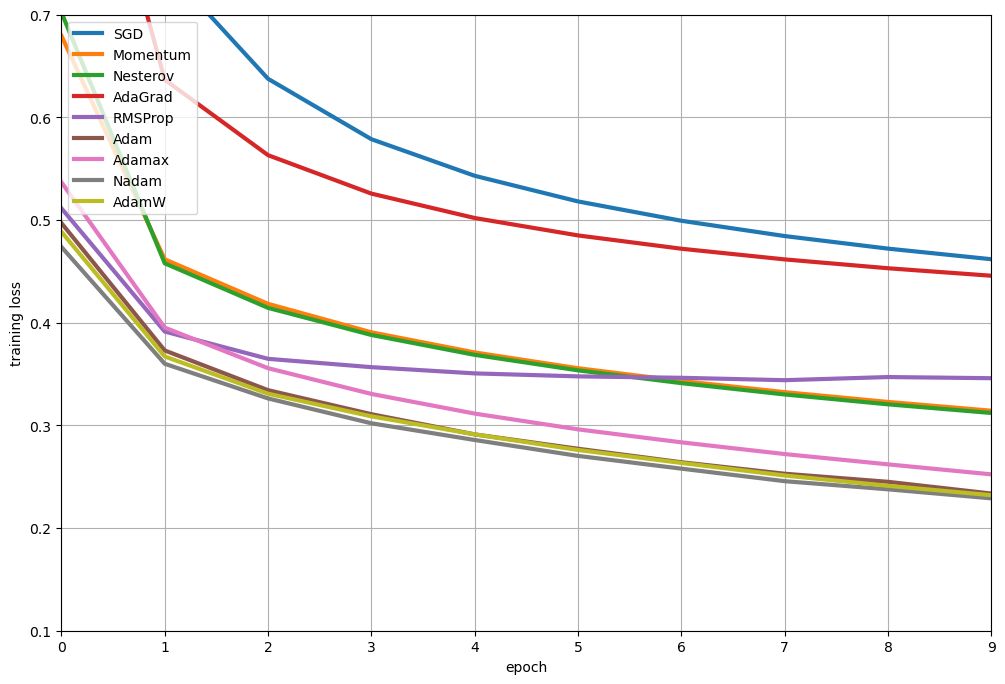

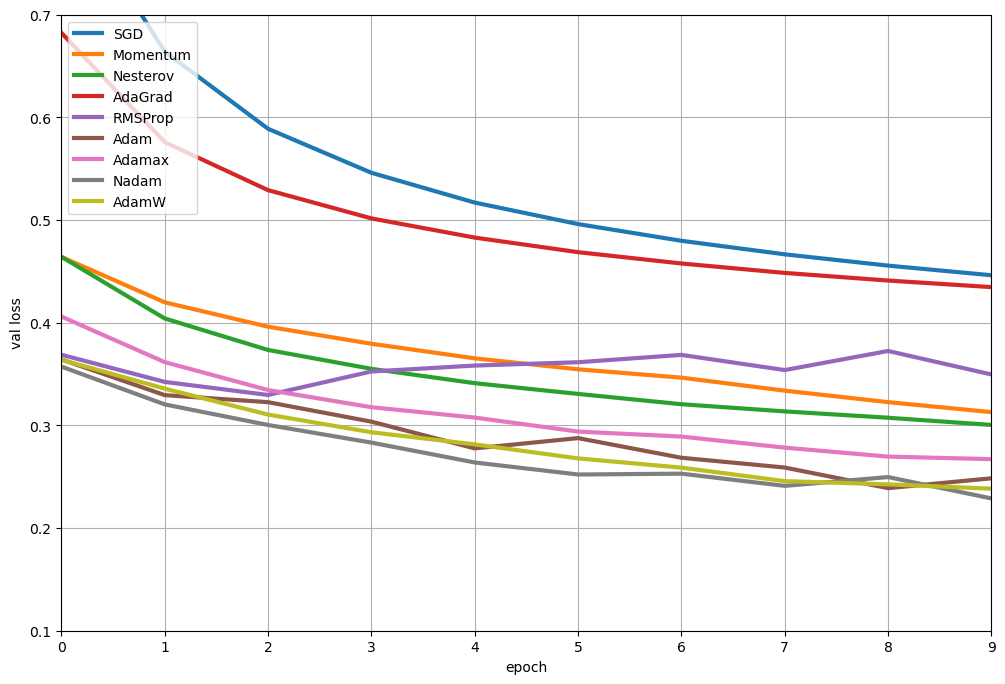

In [33]:
import matplotlib.pyplot as plt

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("epoch")
    plt.ylabel({"loss": "training loss", "val_loss": "val loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

### 11.3.9 Learning Rate Scheduling

| **스케쥴링 방식**     | **설명**                                                                                        | **장점**                                                             | **단점**                                                      | **적합한 상황**                                                             | **학습 속도**  | **수렴 품질** |
| --------------------- | ----------------------------------------------------------------------------------------------- | -------------------------------------------------------------------- | ------------------------------------------------------------- | --------------------------------------------------------------------------- | -------------- | ------------- |
| **고정 학습률**       | - 학습률이 일정하게 유지됨.                                                                     | - 단순하고 안정적.                                                   | - 최적값 근처에서 학습이 비효율적.                            | - 간단한 네트워크나 작은 데이터셋.<br>- 성능 조정이 덜 중요한 경우.         | 중간           | 중간          |
| **계단형 감소**       | - 일정 에포크마다 학습률을 일정 비율로 감소.                                                    | - 구현이 간단.<br>- 학습 초기에는 큰 학습률로 빠르게 학습 가능.      | - 감소 지점과 비율을 잘못 설정하면 학습이 비효율적일 수 있음. | - 고정된 단계에서 성능을 점진적으로 개선해야 하는 경우.                     | 초기 빠름      | 중간~좋음     |
| **지수적 감소**       | - 학습률을 에포크에 따라 지수적으로 감소: \(\eta_t = \eta_0 \cdot e^{-\text{decay} \cdot t}\).  | - 학습 초기에 빠르게 수렴 가능.<br>- 수식이 단순함.                  | - 학습 후반부에 학습률이 지나치게 작아질 수 있음.             | - 일정하게 감소가 필요한 작업.<br>- 손실 함수가 단순한 경우.                | 초기 매우 빠름 | 중간~좋음     |
| **Cosine Decay**      | - 학습률이 코사인 곡선을 따라 감소: \(\eta_t = \frac{1}{2} \eta_0 (1 + \cos(\frac{t}{T}\pi))\). | - 학습률이 점진적으로 감소하며 안정적.                               | - 설정된 사이클이 잘못되면 비효율적일 수 있음.                | - NLP, Transformer 등에서 자주 사용.<br>- 긴 학습 시간.                     | 초기 빠름      | 좋음          |
| **Warmup + Decay**    | - 초기 몇 에포크 동안 학습률을 선형으로 증가(warmup) 후, 감소.                                  | - 초기에 작은 학습률로 안정적 학습 시작 가능.<br>- 이후 빠르게 수렴. | - 적절한 warmup 기간을 설정해야 함.                           | - 매우 깊은 네트워크.<br>- Transformer, BERT 등 최신 모델.                  | 초기에 느림    | 매우 좋음     |
| **1Cycle Policy**     | - 초기에 학습률을 선형 증가, 중간에 감소, 마지막에 미세 조정.                                   | - 빠른 수렴.<br>- 적은 에포크로도 좋은 결과 가능.                    | - 설정이 복잡하고 파라미터 튜닝 필요.                         | - 제한된 학습 시간.<br>- 학습 데이터가 적고 빠르게 수렴이 필요한 경우.      | 빠름           | 매우 좋음     |
| **Reduce on Plateau** | - 손실 감소가 정체되면 학습률을 감소.                                                           | - 학습률 감소가 자동으로 이루어짐.<br>- 과적합 방지 가능.            | - 손실 감소 지점을 잘못 설정하면 비효율적.                    | - 손실 감소 속도가 불균형한 네트워크.<br>- 초기에 빠른 수렴 후 안정화 필요. | 초기 중간      | 좋음          |


In [28]:
# Reduced On Plateau
def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')  # 10 classes
    ])
    return model

model = create_model()

model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, callbacks=[lr_scheduler])

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step - accuracy: 0.6618 - loss: 1.0271 - val_accuracy: 0.8276 - val_loss: 0.5044 - learning_rate: 0.0100
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step - accuracy: 0.8222 - loss: 0.5174 - val_accuracy: 0.8448 - val_loss: 0.4428 - learning_rate: 0.0100
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - accuracy: 0.8396 - loss: 0.4625 - val_accuracy: 0.8556 - val_loss: 0.4121 - learning_rate: 0.0100
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step - accuracy: 0.8512 - loss: 0.4309 - val_accuracy: 0.8608 - val_loss: 0.3897 - learning_rate: 0.0100
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step - accuracy: 0.8583 - loss: 0.4082 - val_accuracy: 0.8658 - val_loss: 0.3746 - learning_rate: 0.0100
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step - accuracy: 0.8639 - loss: 0.3915 - val_accuracy: 0.8714 - val_loss: 0.3618 - learning_rate: 0.0100
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 388us/step - accura

In [30]:
model = create_model()

model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

# Exponential_decay
# Create a closure
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch /s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0 = 0.01, s = 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, callbacks=[lr_scheduler], epochs=20)


Epoch 1/20
   2/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - accuracy: 0.0938 - loss: 2.3948  

/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 369us/step - accuracy: 0.6796 - loss: 1.0290 - learning_rate: 0.0100
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 366us/step - accuracy: 0.8215 - loss: 0.5101 - learning_rate: 0.0089
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 355us/step - accuracy: 0.8399 - loss: 0.4570 - learning_rate: 0.0079
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 364us/step - accuracy: 0.8495 - loss: 0.4282 - learning_rate: 0.0071
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 372us/step - accuracy: 0.8570 - loss: 0.4091 - learning_rate: 0.0063
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 360us/step - accuracy: 0.8624 - loss: 0.3949 - learning_rate: 0.0056
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 364us/step - accuracy: 0.8662 - loss: 0.3837 - learning_rate: 0.0050
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 360us/step - accuracy: 0.8690 - loss: 0.3747 - learning_rate: 0.0045
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 360us/step - accuracy: 0.8715 - loss: 0.3672 - learnin

# 11.4 Regulation

- prevent overfitting and unstable gradient


### 11.4.1 l1 and l2 regularization


In [31]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])



optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 435us/step - accuracy: 0.7147 - loss: 3.9883 - val_accuracy: 0.8232 - val_loss: 1.7375
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 398us/step - accuracy: 0.8113 - loss: 1.5207 - val_accuracy: 0.8244 - val_loss: 1.0584


### 11.4.2 dropout


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

# 추가 코드 - 모델 컴파일 및 훈련
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))